<a href="https://colab.research.google.com/github/brahma1995/Bird_species_classification/blob/main/birds_species_image_classification_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import itertools
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import classification_report, f1_score , confusion_matrix



# Tensorflow Libraries
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout , BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers,models,Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')


print(tf.__version__)

2.12.0


# Loading Dataset

In [ ]:
! pip install Kaggle
!  mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d kedarsai/bird-species-classification-220-categories
!unzip bird-species-classification-220-categories.zip

Streaming output truncated to the last 5000 lines.
  inflating: Train/Horned_Puffin/Horned_Puffin_0029_100888.jpg  
  inflating: Train/Horned_Puffin/Horned_Puffin_0030_100725.jpg  
  inflating: Train/Horned_Puffin/Horned_Puffin_0031_100804.jpg  
  inflating: Train/Horned_Puffin/Horned_Puffin_0033_100731.jpg  
  inflating: Train/Horned_Puffin/Horned_Puffin_0034_100895.jpg  
  inflating: Train/Horned_Puffin/Horned_Puffin_0035_100690.jpg  
  inflating: Train/Horned_Puffin/Horned_Puffin_0036_100974.jpg  
  inflating: Train/Horned_Puffin/Horned_Puffin_0038_100635.jpg  
  inflating: Train/Horned_Puffin/Horned_Puffin_0039_100890.jpg  
  inflating: Train/Horned_Puffin/Horned_Puffin_0040_100891.jpg  
  inflating: Train/Horned_Puffin/Horned_Puffin_0042_100760.jpg  
  inflating: Train/Horned_Puffin/Horned_Puffin_0045_100803.jpg  
  inflating: Train/Horned_Puffin/Horned_Puffin_0046_100785.jpg  
  inflating: Train/Horned_Puffin/Horned_Puffin_0047_100967.jpg  
  inflating: Train/Horned_Puffin/Horned

# Show sample from data

In [ ]:
# Setup Dirs
train_dir = "Train"
test_dir = "Test"

In [ ]:
dataset = {
             "train_data" :train_dir,
             "test_data" : test_dir
          }
all_data = []
for path in dataset.values():
    data = {"imgpath": [] , "labels": [] }
    category = os.listdir(path)

    for folder in category:
        folderpath = os.path.join(path , folder)
        filelist = os.listdir(folderpath)
        for file in filelist:
            fpath = os.path.join(folderpath, file)
            # print(fpath)
            data["imgpath"].append(fpath)
            data["labels"].append(folder)

    all_data.append(data.copy())
    data.clear()


print(len(all_data))
train_df = pd.DataFrame(all_data[0] , index=range(len(all_data[0]['imgpath'])))
test_df = pd.DataFrame(all_data[1] , index=range(len(all_data[1]['imgpath'])))

# #Convert labels to numbers
lb = LabelEncoder()
train_df['encoded_labels'] = lb.fit_transform(train_df['labels'])
test_df['encoded_labels'] = lb.fit_transform(test_df['labels'])

2


# Creating Dataloaders

In [ ]:
%%time

BATCH_SIZE = 35
IMAGE_SIZE = (224, 224)


generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
    # there could be image augmentation here
)

# Split the data into three categories.
train_images = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)


test_images = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 9414 validated image filenames belonging to 200 classes.
Found 2374 validated image filenames belonging to 200 classes.
CPU times: user 73.4 ms, sys: 19.9 ms, total: 93.3 ms
Wall time: 99.1 ms


# Model Structure

In [ ]:
# Load the pretained model
pretrained_model = tf.keras.applications.EfficientNetB5(
    input_shape=(224, 224, 3),
    include_top=False, # we don`t need a pre-trained top layer (output layer)
    weights='imagenet',
    pooling='max'
)

# Freezing the layers of a pretrained neural network
for i, layer in enumerate(pretrained_model.layers):
    pretrained_model.layers[i].trainable = False

115263384/115263384 [==============================] - 0s 0us/step


In [ ]:
num_classes = len(set(train_images.classes))


# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.15),
  layers.experimental.preprocessing.RandomZoom(0.12),
  layers.experimental.preprocessing.RandomContrast(0.12),
], name='AugmentationLayer')



inputs = layers.Input(shape = (224,224,3), name='inputLayer')
x = augment(inputs)
pretrain_out = pretrained_model(x, training = False)
x = layers.Dense(1024)(pretrain_out)
x = layers.Activation(activation="relu")(x)
x = BatchNormalization()(x)
x = layers.Dropout(0.45)(x)
x = layers.Dense(512)(x)
x = layers.Activation(activation="relu")(x)
x = BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(num_classes)(x)
outputs = layers.Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x) # mixed_precision need separated Dense and Activation layers
model = Model(inputs=inputs, outputs=outputs)



model.compile(
    optimizer=Adam(0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 AugmentationLayer (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb5 (Functional)  (None, 2048)             28513527  
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 activation (Activation)     (None, 1024)              0         
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                               

# Training : Transfer Learning

In [ ]:
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=test_images,
    validation_steps=len(test_images),
    epochs=10,
    callbacks=[
        EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 3,
                               restore_best_weights = True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
    ]
)
model.save_weights('./checkpoints/my_checkpoint')

Epoch 1/10
269/269 [==============================] - 109s 301ms/step - loss: 3.8322 - accuracy: 0.1791 - val_loss: 2.3740 - val_accuracy: 0.3985 - lr: 5.0000e-04
Epoch 2/10
269/269 [==============================] - 78s 290ms/step - loss: 2.5107 - accuracy: 0.3631 - val_loss: 1.9975 - val_accuracy: 0.4684 - lr: 5.0000e-04
Epoch 3/10
269/269 [==============================] - 78s 289ms/step - loss: 2.1031 - accuracy: 0.4495 - val_loss: 1.7628 - val_accuracy: 0.5173 - lr: 5.0000e-04
Epoch 4/10
269/269 [==============================] - 83s 307ms/step - loss: 1.8735 - accuracy: 0.5001 - val_loss: 1.6075 - val_accuracy: 0.5497 - lr: 5.0000e-04
Epoch 5/10
269/269 [==============================] - 76s 283ms/step - loss: 1.7203 - accuracy: 0.5280 - val_loss: 1.5414 - val_accuracy: 0.5750 - lr: 5.0000e-04
Epoch 6/10
269/269 [==============================] - 78s 288ms/step - loss: 1.5928 - accuracy: 0.5547 - val_loss: 1.4932 - val_accuracy: 0.5855 - lr: 5.0000e-04
Epoch 7/10
269/269 [=======

# Display model performance

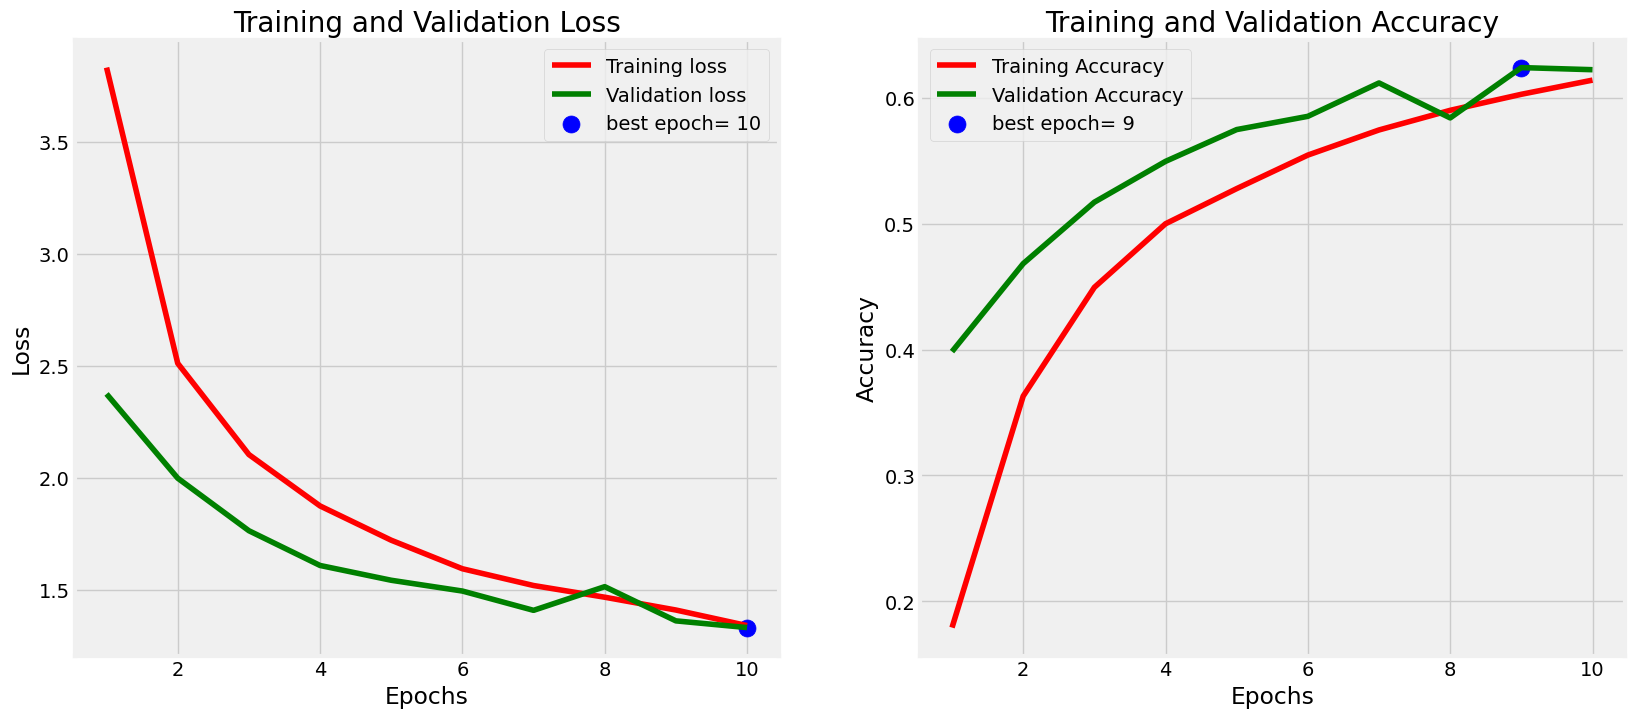

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# Training : Fine Tuning

In [ ]:

model.compile(
    optimizer=Adam(0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=test_images,
    validation_steps=len(test_images),
    epochs=30,
    callbacks=[
        EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 3,
                               restore_best_weights = True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
    ]
)
model.save_weights('./checkpoints/my_checkpoint')

Epoch 1/30
269/269 [==============================] - 214s 488ms/step - loss: 0.6521 - accuracy: 0.8014 - val_loss: 1.2142 - val_accuracy: 0.6891 - lr: 5.0000e-04
Epoch 2/30
269/269 [==============================] - 128s 476ms/step - loss: 0.5770 - accuracy: 0.8235 - val_loss: 1.4290 - val_accuracy: 0.6559 - lr: 5.0000e-04


In [ ]:
pretrained_model.trainable = True
for layer in pretrained_model.layers:
    if isinstance(layer, layers.BatchNormalization): # set BatchNorm layers as not trainable
        layer.trainable = False

# let`s see first 10 layers
for l in pretrained_model.layers[:10]:
    print(l.name, l.trainable)

model.compile(
    optimizer=Adam(0.00001), # fine tuning requires very little learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# model.load_weights('./checkpoints/my_checkpoint')
print(model.summary())
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=test_images,
    validation_steps=len(test_images),
    epochs=20,
    callbacks=[
        EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True), # if val loss decreases for 5 epochs in a row, stop training,
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
    ]
)
model.save_weights('./checkpoints/my_checkpoint')

input_1 True
rescaling True
normalization True
rescaling_1 True
stem_conv_pad True
stem_conv True
stem_bn False
stem_activation True
block1a_dwconv True
block1a_bn False
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 AugmentationLayer (Sequenti  (None, None, None, None)  0        
 al)                                                             
                                                                 
 efficientnetb5 (Functional)  (None, 2048)             28513527  
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 activation (Activation)     (None, 1024)              0         
                       

# Display model performance

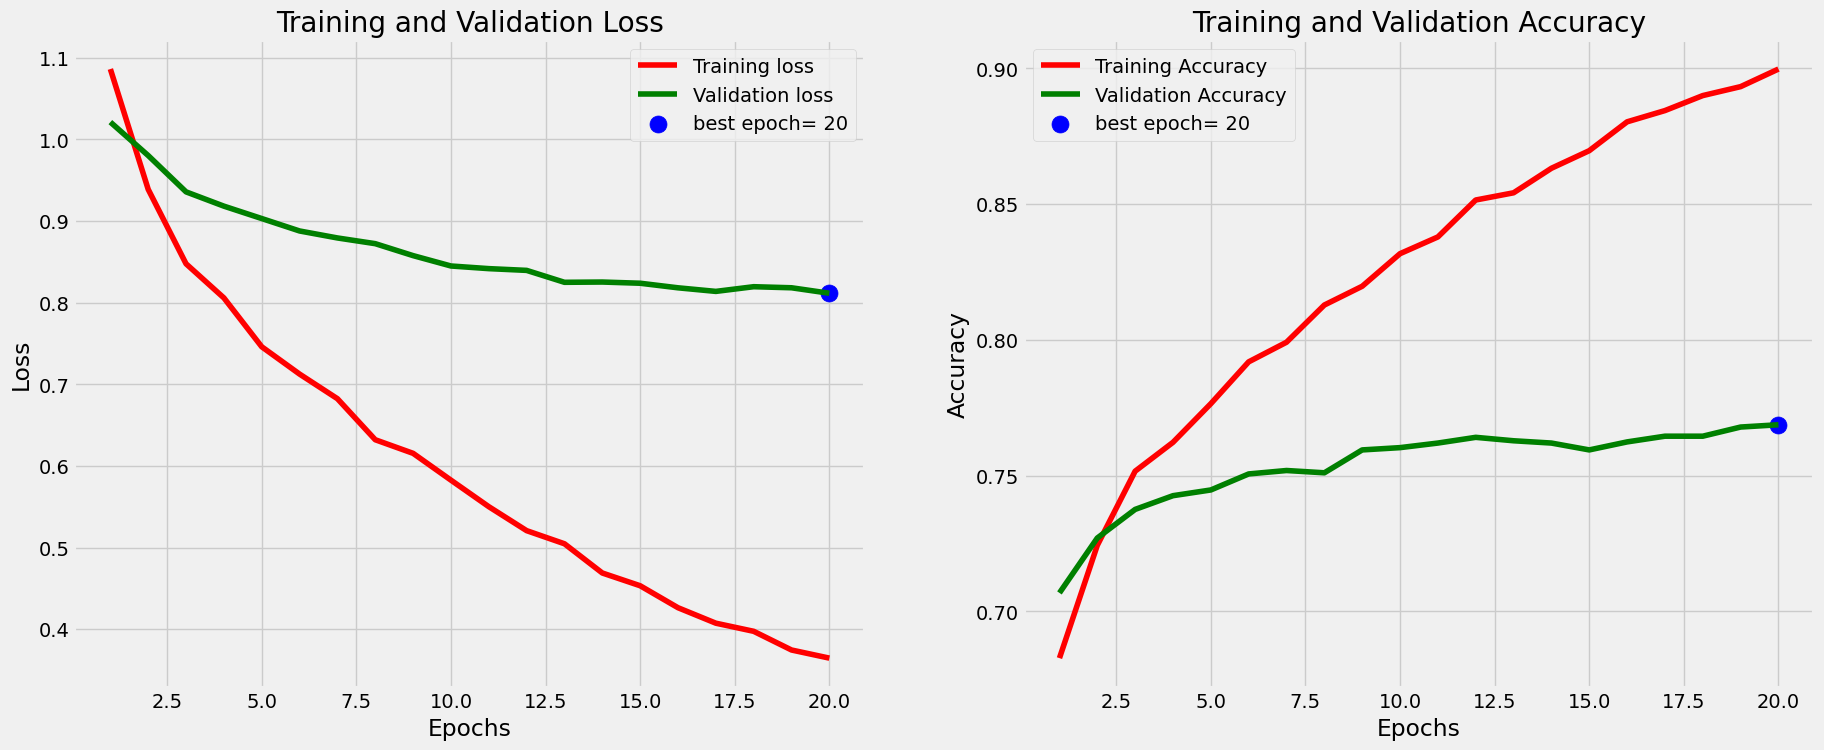

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# model.evaluate

In [ ]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.04511
Test Accuracy: 98.55%


# F1 Score / Recall / Precision

In [ ]:
y_true = test_images.classes
y_pred = np.argmax(model.predict(test_images), axis = 1)
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score:", f1)
print(classification_report(y_true, y_pred, target_names=test_images.class_indices.keys()))

75/75 [==============================] - 12s 99ms/step
F1 Score: 0.9850754536468823
                               precision    recall  f1-score   support

              ABBOTTS BABBLER       1.00      1.00      1.00         5
                ABBOTTS BOOBY       1.00      0.80      0.89         5
   ABYSSINIAN GROUND HORNBILL       1.00      1.00      1.00         5
        AFRICAN CROWNED CRANE       1.00      1.00      1.00         5
       AFRICAN EMERALD CUCKOO       1.00      1.00      1.00         5
            AFRICAN FIREFINCH       1.00      1.00      1.00         5
       AFRICAN OYSTER CATCHER       1.00      1.00      1.00         5
        AFRICAN PIED HORNBILL       1.00      0.80      0.89         5
          AFRICAN PYGMY GOOSE       1.00      1.00      1.00         5
                    ALBATROSS       1.00      1.00      1.00         5
               ALBERTS TOWHEE       1.00      1.00      1.00         5
         ALEXANDRINE PARAKEET       1.00      1.00      1.00   

# Get Predictions

In [ ]:
classes = dict(zip(test_images.class_indices.values(), test_images.class_indices.keys()))
Predictions = pd.DataFrame({"Image Index" : list(range(len(test_images.labels))),
                            "Test Labels" : test_images.labels,
                            "Test Classes" : [classes[i] for i in test_images.labels],
                            "Prediction Labels" : y_pred,
                            "Prediction Classes" : [classes[i] for i in y_pred],
                            "Path": test_images.filenames,
                            "Prediction Probability" : [x for x in np.asarray(tf.reduce_max(model.predict(test_images), axis = 1))]
                           })
Predictions.head(8)

75/75 [==============================] - 8s 99ms/step


Image Index  Test Labels             Test Classes  Prediction Labels  \
0            0          185        DALMATIAN PELICAN                185   
1            1          185        DALMATIAN PELICAN                185   
2            2          185        DALMATIAN PELICAN                185   
3            3          185        DALMATIAN PELICAN                185   
4            4          185        DALMATIAN PELICAN                185   
5            5           75  BLACK BREASTED PUFFBIRD                 75   
6            6           75  BLACK BREASTED PUFFBIRD                 75   
7            7           75  BLACK BREASTED PUFFBIRD                 75   

        Prediction Classes                                               Path  \
0        DALMATIAN PELICAN  /kaggle/input/100-bird-species/test/DALMATIAN ...   
1        DALMATIAN PELICAN  /kaggle/input/100-bird-species/test/DALMATIAN ...   
2        DALMATIAN PELICAN  /kaggle/input/100-bird-species/test/DALMATIAN ...   
3        DALMATIAN PELICAN  /kaggle/input/100-bird-species/test/DALMATIAN ...   
4        DALMATIAN PELICAN  /kaggle/input/100-bird-species/test/DALMATIAN ...   
5  BLACK BREASTED PUFFBIRD  /kaggle/input/100-bird-species/test/BLACK BREA...   
6  BLACK BREASTED PUFFBIRD  /kaggle/input/100-bird-species/test/BLACK BREA...   
7  BLACK BREASTED PUFFBIRD  /kaggle/input/100-bird-species/test/BLACK BREA...   

   Prediction Probability  
0                0.999941  
1                0.999983  
2                0.999977  
3                0.999987  
4                0.999963  
5                0.999983  
6                0.999720  
7                0.999497

# Print the most confident errors

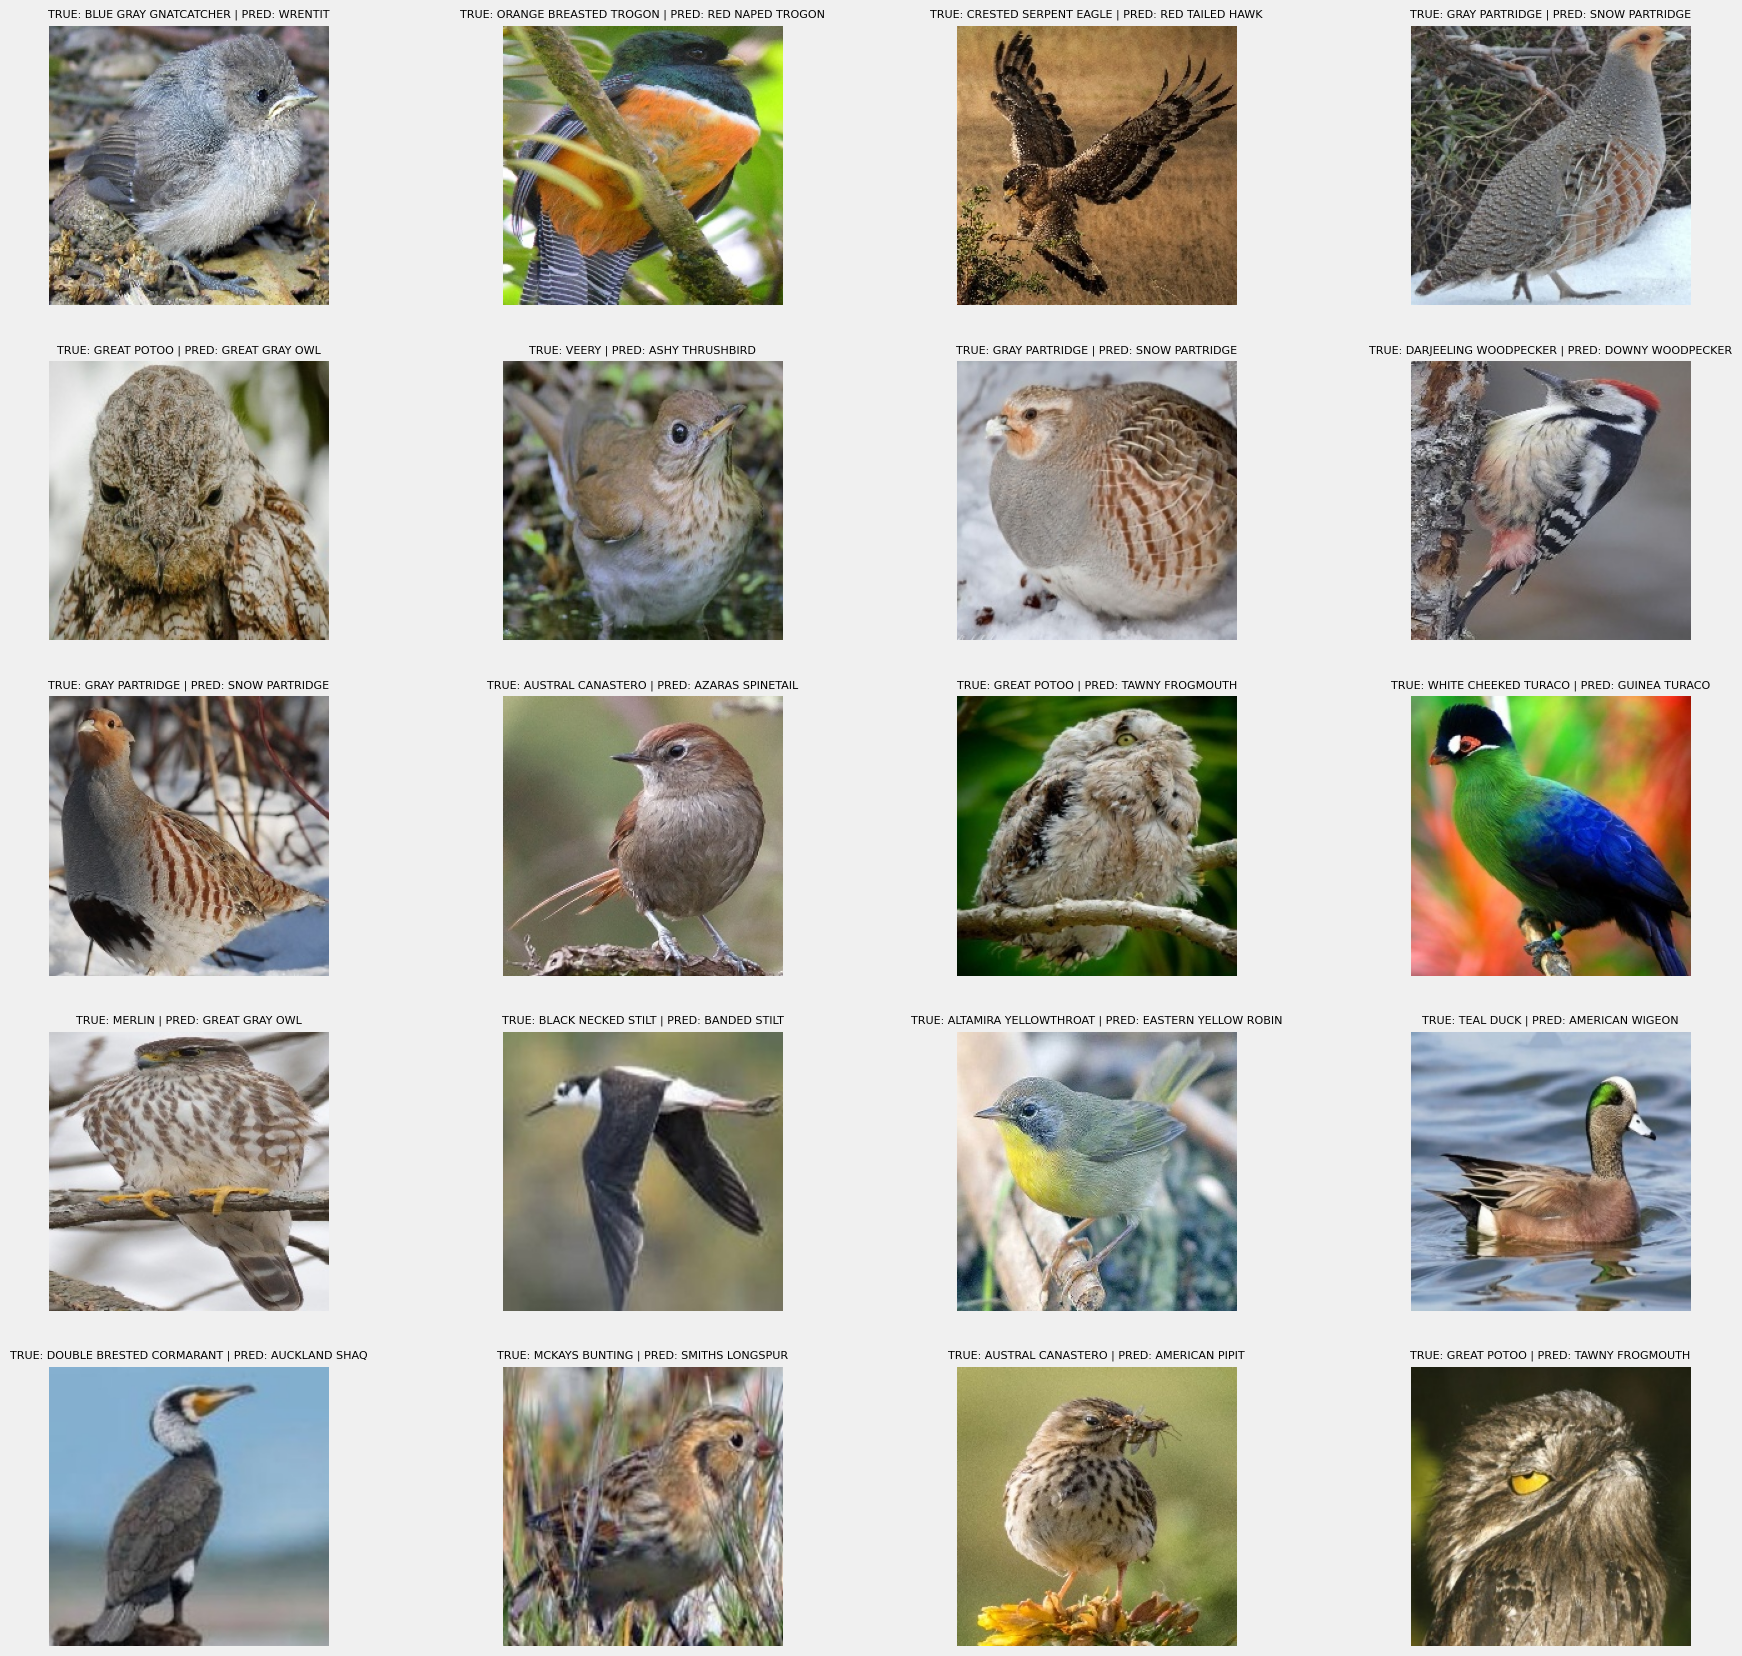

In [ ]:
plt.figure(figsize=(20,20))
for i, row in Predictions[Predictions["Test Labels"] != Predictions["Prediction Labels"]].sort_values("Prediction Probability").tail(20).reset_index().iterrows():
    plt.subplot(5,4,i+1)
    image_path = row['Path']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f'TRUE: {row["Test Classes"]} | PRED: {row["Prediction Classes"]}', fontsize=8)
    plt.axis('off')

plt.show()

# Confusion Matrics and Classification Report

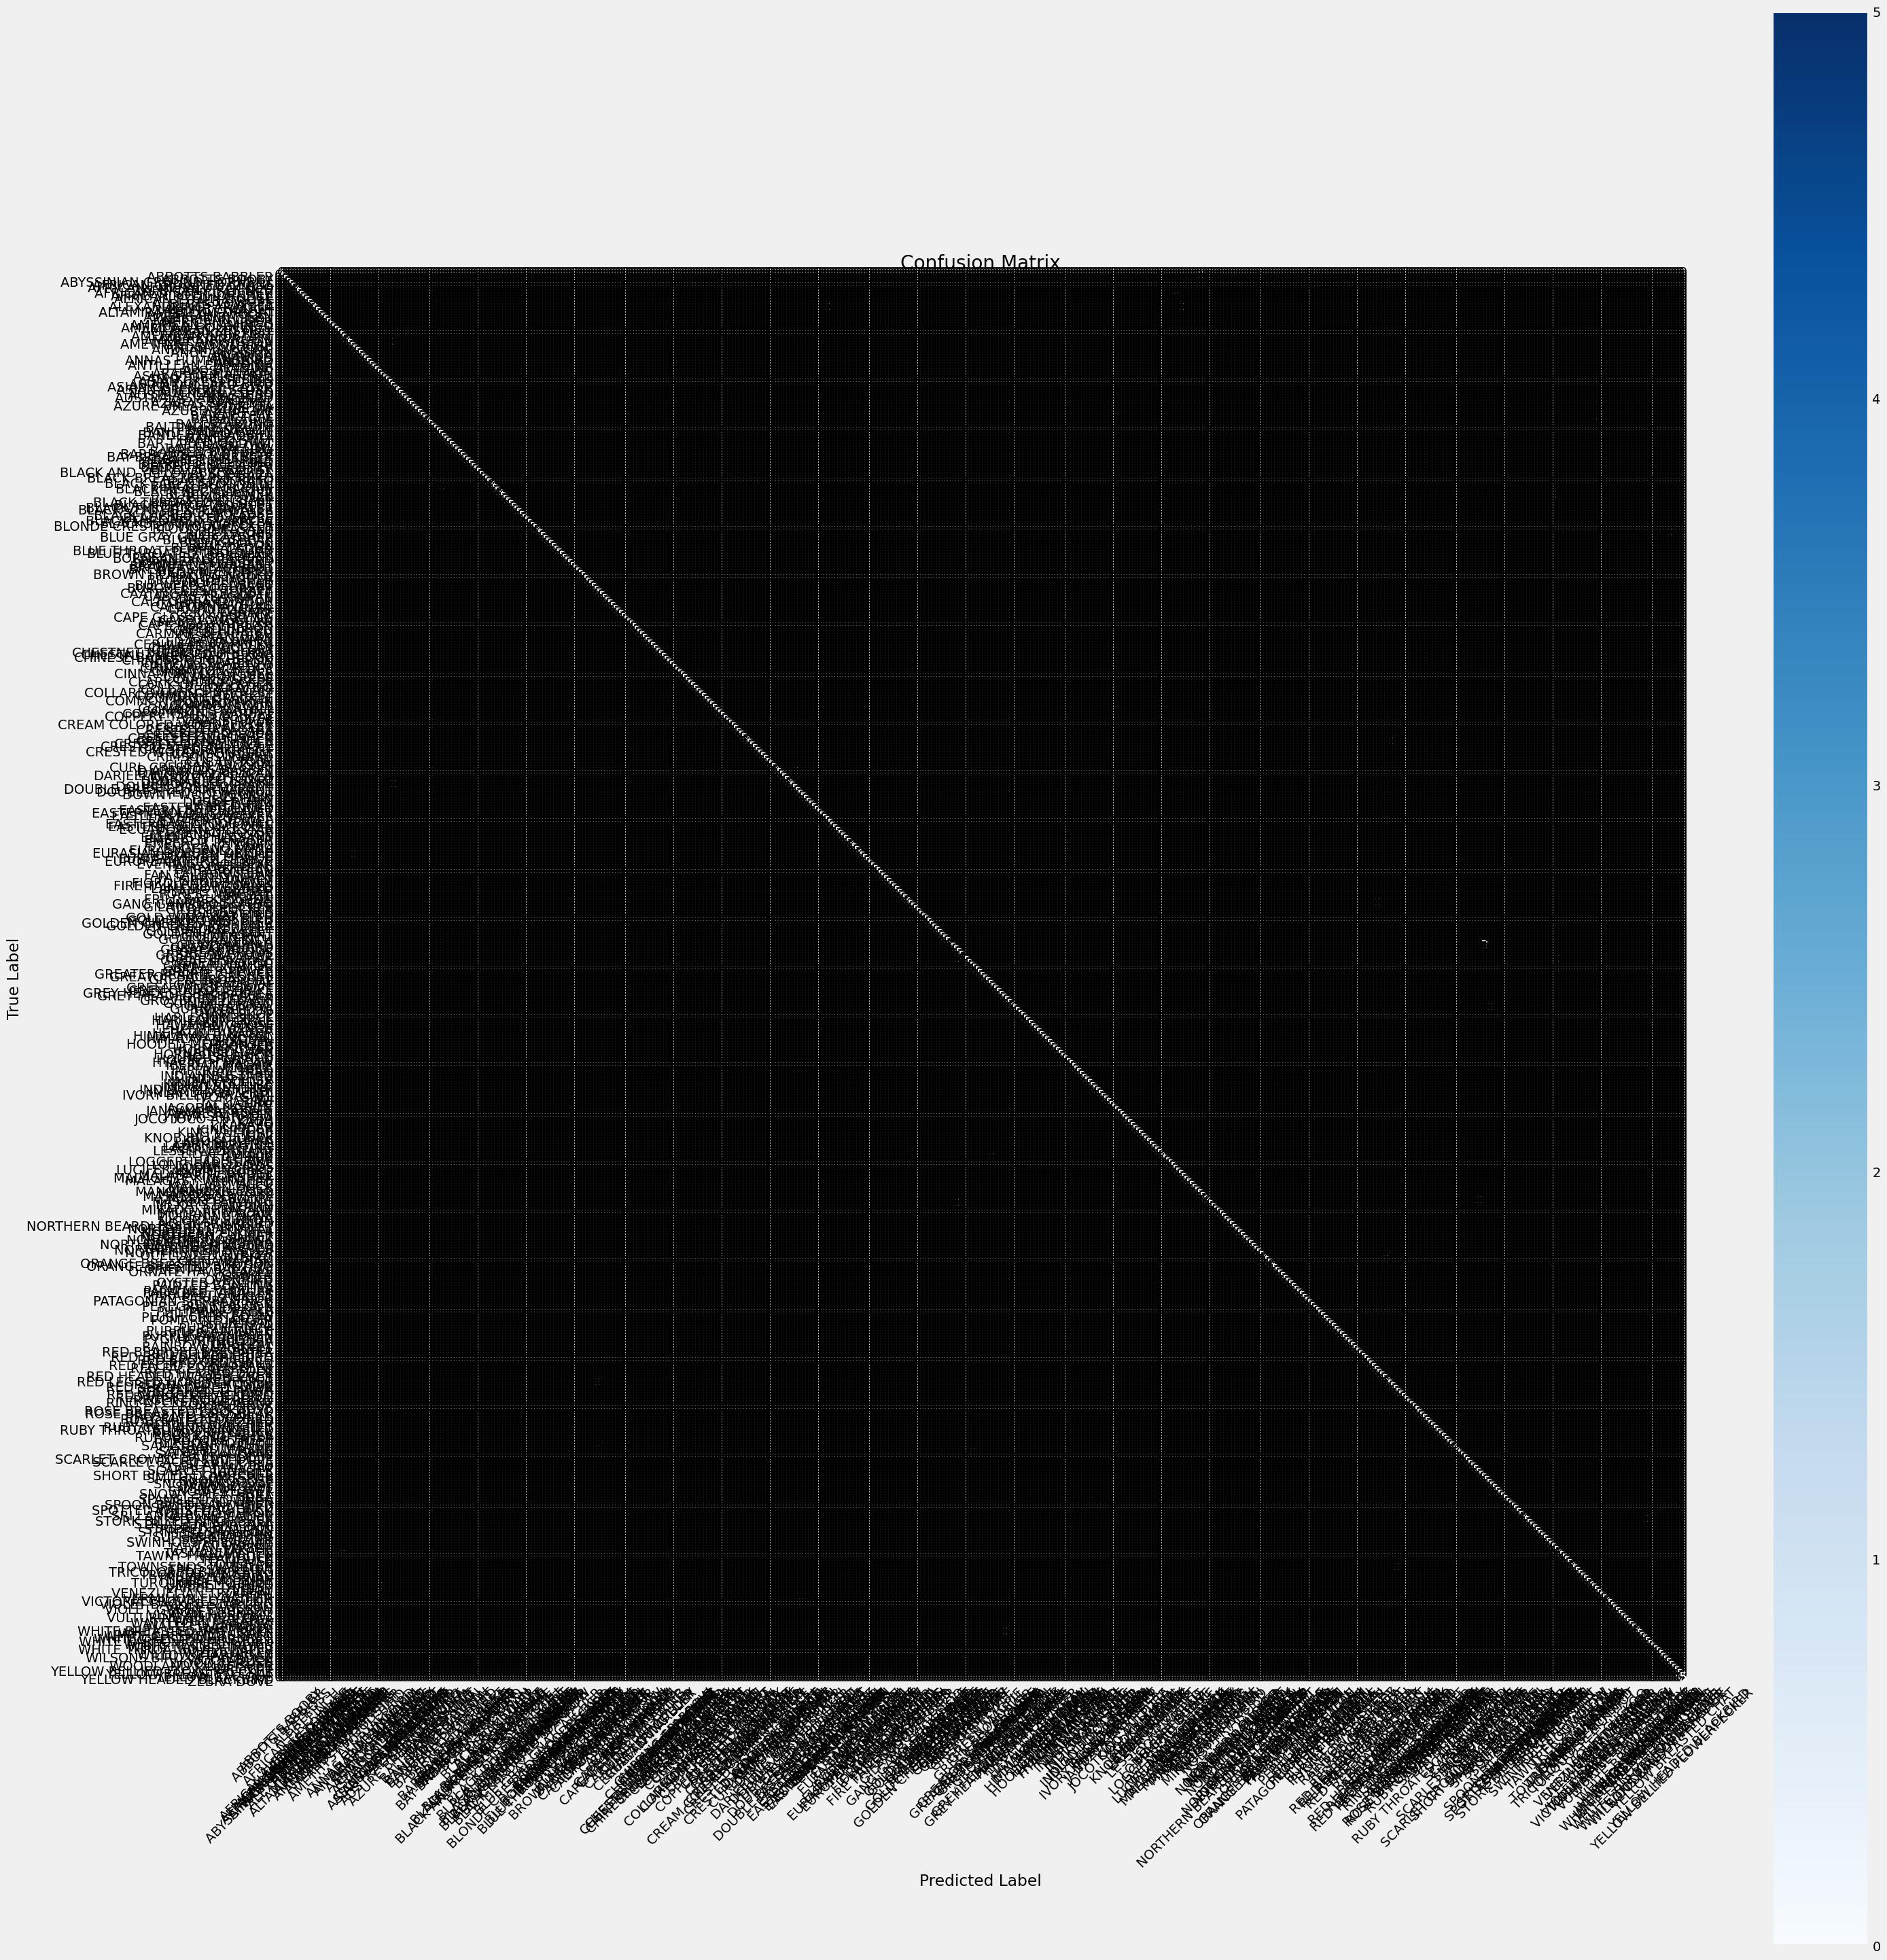

In [ ]:
preds = model.predict_generator(test_images)
y_pred = np.argmax(preds, axis=1)
g_dict = test_images.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_images.classes, y_pred)

plt.figure(figsize= (30, 30))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()